# Initialization

In [179]:
%reload_ext autoreload
%autoreload 2

In [180]:
from result_saver import SaverProvider

provider = SaverProvider()

# Initialize simulator

In [391]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 7
ROUNDS = 7
OTHER_DATE = '2021-11-11'
_RESETS = False
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

# Initialize stim circuit

In [392]:
# AFTER_CLIFFORD_DEPOLARIZATION = 0.8e-3
# AFTER_RESET_FLIP_PROBABILITY = 0.1e-2
# BEFORE_MEASURE_FLIP_PROBABILITY = 0.5e-2 
# BEFORE_ROUND_DATA_DEPOLARIZATION = 0.8e-2

# Good error rate _resets = True
AFTER_CLIFFORD_DEPOLARIZATION = 3e-2
AFTER_RESET_FLIP_PROBABILITY = 0.8e-2
BEFORE_MEASURE_FLIP_PROBABILITY = 1e-2 
BEFORE_ROUND_DATA_DEPOLARIZATION = 3e-2

# AFTER_CLIFFORD_DEPOLARIZATION = 3e-9
# AFTER_RESET_FLIP_PROBABILITY = 0.8e-9
# BEFORE_MEASURE_FLIP_PROBABILITY = 1e-9
# BEFORE_ROUND_DATA_DEPOLARIZATION = 3e-9


SHOTS = int(1e4)

In [393]:
import stim
stim_circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=DISTANCE,
                                rounds=ROUNDS,
                                after_clifford_depolarization=AFTER_CLIFFORD_DEPOLARIZATION, #two-qubit-fidelity,
                                after_reset_flip_probability=AFTER_RESET_FLIP_PROBABILITY, #reset error,
                                before_measure_flip_probability=BEFORE_MEASURE_FLIP_PROBABILITY, #measurement error,
                                before_round_data_depolarization=BEFORE_ROUND_DATA_DEPOLARIZATION) #idle error)



meas_outcomes = stim_circuit.compile_sampler().sample(SHOTS)
counts = {}
for row in meas_outcomes:
    count_str = ''
    for nb, bit in enumerate(row):
        count_str += '0' if bit == False else '1'
        if (nb+1) % (DISTANCE-1) == 0 and nb < ROUNDS*(DISTANCE-1):
            count_str += ' ' 
    count_str = count_str[::-1]
    if count_str in counts:
        counts[count_str] += 1
    else:
        counts[count_str] = 1
print(counts)

{'0010001 011000 011000 011000 011000 000000 000000 000000': 1, '1001100 101010 101010 001010 001010 011100 001100 000001': 1, '0100100 110010 110110 110110 110110 010000 000000 000000': 1, '1000010 111011 111011 100011 000001 000000 000000 000000': 1, '0000001 000001 000001 010000 000000 000010 000000 000000': 1, '0110000 110000 110000 110000 110000 110000 111000 110000': 1, '0110001 011001 101011 011001 011000 000000 000000 000000': 1, '0000000 000000 000000 000000 000000 000000 000000 001000': 10, '0000001 011101 001101 001101 001101 001101 001101 000100': 1, '0000000 000000 000000 011000 000000 000100 000000 000000': 1, '0110100 101110 001110 011110 011100 001000 000000 000000': 1, '0000000 000000 000000 000000 000001 000000 100000 000000': 1, '0010001 011001 001001 001001 001101 001101 001101 011001': 1, '0100001 111000 110000 110000 110010 110000 000000 000000': 1, '1010000 111010 110100 101100 101100 100000 100000 010000': 1, '1000000 110000 100000 100000 100000 100000 000000 00

In [394]:
# not correct if we look at the count string!
verbose = False

no_reset_counts = {}
for count_key, shots in counts.items():
    parts=count_key.split(" ")
    print("parts:", parts) if verbose else None
    count_part = parts[0]
    print("count_part:", count_part) if verbose else None  
    check_parts = parts[1:]
    print("check_parts:", check_parts, "\n") if verbose else None

    for i in range(len(check_parts)):
        if i == 0:
            print("skipped last check part:", check_parts[-1], "\n") if verbose else None
            continue
        current_check_str = check_parts[-(i+1)]
        print("current_check_str:", current_check_str) if verbose else None
        prev_check_str = check_parts[-i]
        print("prev_check_str:", prev_check_str) if verbose else None
        new_check_str = ''
        for bit1, bit2 in zip(prev_check_str, current_check_str):
            new_check_str += str(int(bit1)^int(bit2))
        print("new_check_str:", new_check_str, "\n") if verbose else None
        check_parts[-(i+1)] = new_check_str

    print("\ncheck_parts after modulo:", check_parts) if verbose else None

    new_count_str = count_part + " " +  ' '.join(check_parts)
    print("\nnew_count_str:", new_count_str) if verbose else None

    
    if new_count_str in no_reset_counts:
        no_reset_counts[new_count_str] += shots
    else:
        no_reset_counts[new_count_str] = shots

if _RESETS is False:
    print("Taking no reset counts")
    counts = no_reset_counts
else: 
    print("Taking reset counts")

print(counts)

Taking no reset counts
{'0010001 000000 011000 000000 011000 000000 000000 000000': 1, '1001100 010001 111011 010001 011011 010001 001101 000001': 1, '0100100 010100 100110 010000 100110 010000 000000 000000': 1, '1000010 100010 011001 100010 000001 000000 000000 000000': 1, '0000001 010010 010011 010010 000010 000010 000000 000000': 1, '0110000 111000 001000 111000 001000 111000 001000 110000': 1, '0110001 110011 101010 000001 011000 000000 000000 000000': 1, '0000000 001000 001000 001000 001000 001000 001000 001000': 10, '0000001 010100 001001 000100 001001 000100 001001 000100': 1, '0000000 011100 011100 011100 000100 000100 000000 000000': 1, '0110100 101010 000100 001010 010100 001000 000000 000000': 1, '0000000 100001 100001 100001 100001 100000 100000 000000': 1, '0010001 001101 010100 011101 010100 011001 010100 011001': 1, '0100001 111010 000010 110010 000010 110000 000000 000000': 1, '1010000 011110 100100 010000 111100 010000 110000 010000': 1, '1000000 110000 000000 100000 

In [395]:
P_AMBIG = 0

iq_dict = simulator.generate_IQ_dict()
extreme_IQ_data = simulator.counts_to_IQ_extreme(P_AMBIG, iq_dict, counts)

 61%|██████    | 5342/8824 [00:02<00:01, 3029.94it/s]

# Get counts from IQ data

In [ ]:
import cpp_soft_info

print(cpp_soft_info.get_counts(extreme_IQ_data, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))

{'0000000 000000 000000 000000 000000 000000 000000 000000': 195, '0000000 000000 000000 000000 000000 000000 000000 000001': 8, '0000000 000000 000000 000000 000000 000000 000000 000010': 9, '0000000 000000 000000 000000 000000 000000 000000 000100': 9, '0000000 000000 000000 000000 000000 000000 000000 000101': 1, '0000000 000000 000000 000000 000000 000000 000000 001000': 7, '0000000 000000 000000 000000 000000 000000 000000 001100': 2, '0000000 000000 000000 000000 000000 000000 000000 010000': 6, '0000000 000000 000000 000000 000000 000000 000000 010010': 1, '0000000 000000 000000 000000 000000 000000 000000 011000': 1, '0000000 000000 000000 000000 000000 000000 000000 100000': 4, '0000000 000000 000000 000000 000000 000000 000000 100001': 1, '0000000 000000 000000 000000 000000 000000 000000 100010': 1, '0000000 000000 000000 000000 000000 000000 000001 000000': 6, '0000000 000000 000000 000000 000000 000000 000010 000000': 7, '0000000 000000 000000 000000 000000 000000 000010 0

# Decode IQ data

In [ ]:
import pymatching
import stim

model = stim_circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

P_MEAS = P_AMBIG

In [ ]:
import cpp_soft_info

matching = pymatching.Matching.from_detector_error_model(model)
# cpp_soft_info.reweight_edges_based_on_error_probs(matching._matching_graph, counts, False, "spitz")

result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=False, _bimodal=True, merge_strategy = "replace", _detailed=True, p_offset = 1)
print("num_errors:", result.num_errors, "out of", len(extreme_IQ_data), "shots")

num_errors: 99 out of 10000 shots


In [ ]:
matching = pymatching.Matching.from_detector_error_model(model)
result_flat = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=True)
print("num_errors:", result_flat.num_errors, "out of", len(extreme_IQ_data), "shots")


num_errors: 105 out of 10000 shots


In [390]:
matching = pymatching.Matching.from_detector_error_model(model)

p_meas = -1
# p_meas = 19e-2


result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=True)

print("num_errors:", result_informed.num_errors, "out of", len(extreme_IQ_data), "shots")
         
# takes 1s

num_errors: 96 out of 10000 shots


# Plot the results

In [13]:
print("\nIQ:", result.indices, "\nFlat:", result_flat.indices, "\nInformed", result_informed.indices)


IQ: [5, 7, 9, 10, 15, 21, 28, 40, 67, 68, 70, 80, 262, 263, 274, 282, 286, 287, 290, 300, 301, 307, 311, 350, 352, 353, 355, 372, 373, 374, 378, 380, 383, 393, 395, 402, 404, 410, 411, 432, 441, 465, 466, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 484, 486, 489, 507, 509, 515, 518, 521, 561, 564, 588, 597, 598, 636, 637, 638, 644, 647, 648, 708, 727, 728, 732, 752, 753, 760, 762, 764, 779, 780, 789, 800, 803, 804, 806, 815, 816, 817, 818, 819, 821, 822, 823, 824, 825, 826, 827, 828, 841, 842, 848, 852, 853, 859, 866, 869, 874, 885, 895, 902, 917, 919, 921, 925, 926, 927, 928, 929, 930, 931, 932, 933, 949, 950, 953, 964, 965, 966, 990, 994, 1000, 1002, 1012, 1019, 1020, 1051, 1068, 1076, 1079, 1094, 1113, 1122, 1144, 1165, 1166, 1170, 1176, 1178, 1206, 1221, 1252, 1254, 1264, 1266, 1272, 1274, 1275, 1276, 1284, 1286, 1296, 1298, 1305, 1332, 1334, 1335, 1336, 1339, 1340, 1357, 1361, 1367, 1368, 1369, 1372, 1373, 1374, 1389, 1398, 1401, 1407, 1412, 1422, 1429, 1436, 1437, 1452, 14

-----IQ-----


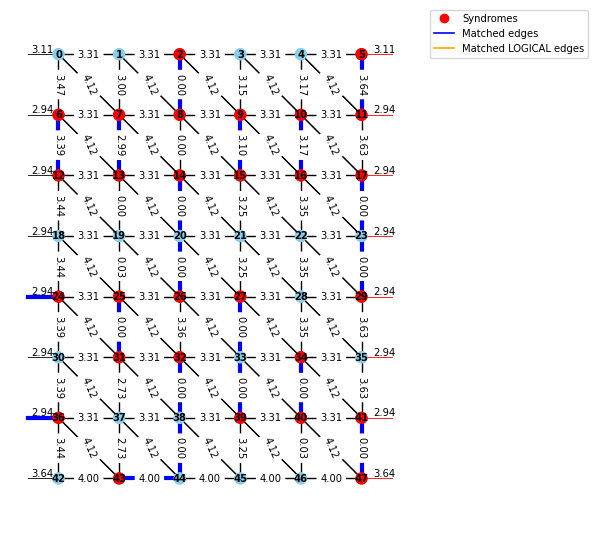

-----flat-----


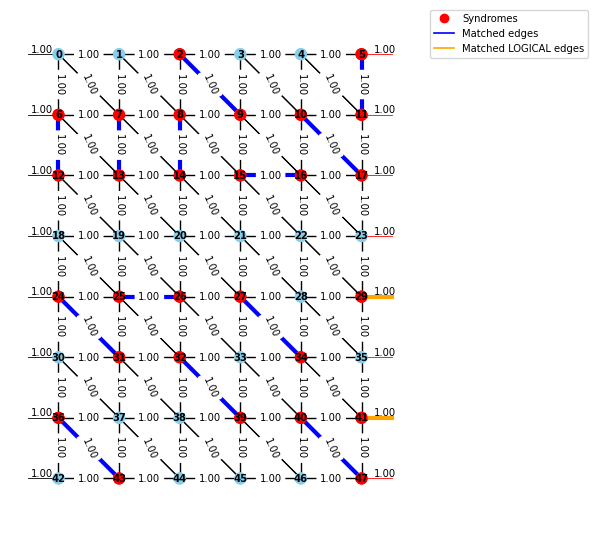

-----INFORMED-----


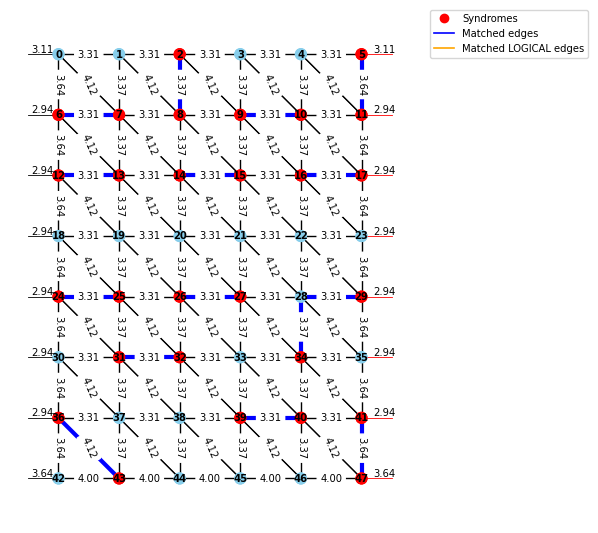

In [14]:
from soft_info import draw_matching_graph


index = 20

fig_size = (4, 13)
scale_factor = 0.6

to_be_result = result
details = to_be_result.error_details[index]
print("-----IQ-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_flat
details = to_be_result.error_details[index]
print("-----flat-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_informed
details = to_be_result.error_details[index]
print("-----INFORMED-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


In [15]:
informed_not_in_iq = sorted(set(result_informed.indices) - set(result.indices))
print("indices that are in informed but not in IQ with len:", len(informed_not_in_iq))
print(informed_not_in_iq)
iq_not_in_informed = sorted(set(result.indices) - set(result_informed.indices))
print("indices that are in IQ but not in informed with len:", len(iq_not_in_informed))
print(iq_not_in_informed)

print()

iq_not_in_flat = sorted(set(result.indices) - set(result_flat.indices))
print("indices that are in IQ but not in flat with len:", len(iq_not_in_flat))
print(iq_not_in_flat)
flat_not_in_iq = sorted(set(result_flat.indices) - set(result.indices))
print("indices that are in flat but not in IQ with len:", len(flat_not_in_iq))
print(flat_not_in_iq)

indices that are in informed but not in IQ with len: 2769
[1, 2, 4, 6, 8, 11, 13, 18, 22, 25, 27, 30, 31, 37, 38, 39, 42, 44, 49, 54, 65, 72, 75, 77, 85, 86, 90, 92, 97, 110, 111, 113, 118, 122, 131, 133, 137, 138, 155, 169, 170, 172, 174, 184, 185, 196, 205, 212, 213, 215, 222, 224, 227, 232, 238, 239, 249, 252, 256, 258, 266, 267, 269, 270, 275, 277, 278, 285, 288, 291, 293, 296, 299, 302, 306, 312, 315, 319, 324, 327, 329, 330, 333, 336, 340, 344, 345, 351, 357, 361, 363, 365, 369, 377, 379, 382, 386, 387, 388, 391, 394, 399, 403, 406, 409, 415, 417, 418, 419, 421, 422, 424, 425, 426, 427, 429, 430, 431, 434, 436, 440, 443, 449, 452, 453, 458, 460, 462, 478, 480, 487, 492, 495, 506, 508, 514, 524, 525, 527, 528, 530, 531, 535, 541, 544, 546, 548, 550, 551, 553, 562, 563, 566, 569, 575, 582, 583, 586, 596, 599, 601, 602, 610, 611, 615, 619, 620, 621, 624, 625, 629, 632, 634, 635, 646, 650, 651, 652, 657, 660, 662, 665, 666, 669, 673, 676, 677, 678, 682, 685, 692, 693, 697, 701, 702, 

# Analyse specific shots

In [16]:
from tqdm import tqdm

index = 64
IQ_data = extreme_IQ_data[index:index+1]

esult = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=True)


print(cpp_soft_info.get_counts(IQ_data, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))



to_be_result = esult
details = to_be_result.error_details[0]


mean_edge_weight = 0
num_time_edges = 0
for edge in tqdm(matching.edges()):
    src_node, tgt_node, data = edge
    if src_node == None or tgt_node == None:
        continue
    if src_node == tgt_node - (DISTANCE-1):
        mean_edge_weight += data["weight"]
        num_time_edges += 1

print("mean time edge weight:", mean_edge_weight / num_time_edges)

print("-----IQ-----")
# draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        # matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

{'0000000 000000 100000 111111 111111 111010 000001 000000': 1}


100%|██████████| 133/133 [00:00<00:00, 1460320.50it/s]

mean time edge weight: 2.763497672024338
-----IQ-----
